# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [107]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [108]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [161]:
from torch.utils.data import DataLoader

def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    transform = transforms.Compose([transforms.Resize(image_size), # resize to image_size
                                    transforms.ToTensor()]) 
    
    dataset = datasets.ImageFolder(data_dir, transform)
    
        
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [162]:
# Define function hyperparameters
batch_size = 16 
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

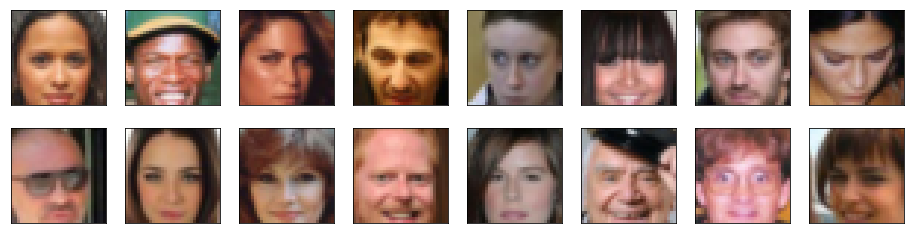

In [163]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(16, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [164]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [165]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8588)
Max:  tensor(0.9765)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [166]:
import torch.nn as nn
import torch.nn.functional as F

    Notes:

    Helper files are from CycleGan notebook from exercises: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/CycleGAN_Solution.ipynb

In [167]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [168]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [169]:
# from torch.nn import spectral_norm
    # https://github.com/navneet-nmk/pytorch-rl/blob/master/models/infogan.py
    # https://arxiv.org/abs/1805.08318

In [170]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        self.conv_dim = conv_dim

        
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # (32,32,3) to (16,16,dim)
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (16,16,dim) to (8,8,dim*2)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (8,8,dim*2) to (4,4,dim*4)
        
        # complete init function
        self.fc = nn.Linear(conv_dim*4*4*4, 1) # accepts (4,4,dim*4) to vectorize
        
        # self.dropout = nn.Dropout (0.3)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        out = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        out = F.leaky_relu(self.conv2(out), negative_slope=0.2)
        out = F.leaky_relu(self.conv3(out), negative_slope=0.2)
        
        out = out.view(-1, self.conv_dim*4*4*4)
        # out = self.dropout (out)                
        out = self.fc(out)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [171]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        self.conv_dim = conv_dim
        
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.fc = nn.Linear (z_size, conv_dim*4*4*4)
        self.dropout = nn.Dropout (0.5)
            # self.fc2 = nn.Linear (conv_dim*4*4*4, conv_dim*4*4*4)
        
        self.de_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.de_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.de_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
            # pretty much the inverse of the Discriminator
            
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        out = self.fc(x)
        out = self.dropout(out)
            # out = self.fc2(out) # maybe a secondary dence layer would work help
            # it doesn't
        
        out = out.view(-1, self.conv_dim*4, 4, 4) # de-vectorize
        
        out = F.leaky_relu(self.de_conv1(out), negative_slope=0.2)
        out = F.leaky_relu(self.de_conv2(out), negative_slope=0.2)
        out = self.de_conv3(out)
        out = F.tanh(out) 
            # https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/CycleGAN_Solution.ipynb
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [172]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    if (classname.find ('Linear') > -1): 
            # or (classname.find ('Conv') > -1) : CONV layers are bias = False already
            # https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073
            # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
            # https://pytorch.org/cppdocs/api/function_namespacetorch_1_1nn_1_1init_1a105c2a8ef81c6faa82a01cf35ce9f3b1.html?highlight=distribution
            # https://pytorch.org/cppdocs/api/function_namespacetorch_1_1nn_1_1init_1a105c2a8ef81c6faa82a01cf35ce9f3b1.html#exhale-function-namespacetorch-1-1nn-1-1init-1a105c2a8ef81c6faa82a01cf35ce9f3b1
        m.weight.data.normal_ (0.0, 0.02)  
        m.bias.data.fill_ (0)
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [173]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [174]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 32*3 # three layers?

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=96, out_features=2048, bias=True)
  (dropout): Dropout(p=0.5)
  (de_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [175]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [176]:
# https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/CycleGAN_Solution.ipynb

In [177]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out-1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [178]:
import torch.optim as optim

# hyperparameters

lr==0.0004
beta1=0.3
beta2=0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [179]:
from torch.optim.lr_scheduler import StepLR

In [180]:
#gamma scheduler learning rate decay
gamma = 0.9
step_size = 4

In [181]:
d_scheduler = StepLR(d_optimizer, step_size=step_size, gamma=gamma)
g_scheduler = StepLR(g_optimizer, step_size=step_size, gamma=gamma) 

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [182]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):
        # if
        d_scheduler.step()
        g_scheduler.step()
        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
        
            if train_on_gpu:
                real_images = real_images.cuda()
        
        # get a real image and decide
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
                
        # making fake image vector
        # and run through generator
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda() # forgot this the first time
            fake_images = G(z)
        
                
        # get a fake image and decide                
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward(retain_graph=True)
            d_optimizer.step() 

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad() # always

        # making fake image vector
        # and run through generator
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda() # forgot this the first time
            
            D_fake = D(fake_images)
        # flipped, inverse real loss = fake loss
            g_loss = real_loss(D_fake)

            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 13:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f} | \n'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item(), ))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

    graph retention : https://discuss.pytorch.org/t/runtimeerror-trying-to-backward-through-the-graph-a-second-time-but-the-buffers-have-already-been-freed-specify-retain-graph-true-when-calling-backward-the-first-time/6795

In [183]:
# set number of epochs 
n_epochs = 12


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   12] | d_loss: 0.3821 | g_loss: 0.6707 | 

Epoch [    1/   12] | d_loss: 1.1089 | g_loss: 0.2149 | 

Epoch [    1/   12] | d_loss: 0.5580 | g_loss: 0.5531 | 

Epoch [    1/   12] | d_loss: 0.6617 | g_loss: 1.4285 | 

Epoch [    1/   12] | d_loss: 0.4087 | g_loss: 0.9338 | 

Epoch [    1/   12] | d_loss: 0.4497 | g_loss: 0.5709 | 

Epoch [    1/   12] | d_loss: 0.4828 | g_loss: 0.5972 | 

Epoch [    1/   12] | d_loss: 0.7092 | g_loss: 0.3501 | 

Epoch [    1/   12] | d_loss: 0.7817 | g_loss: 1.0504 | 

Epoch [    1/   12] | d_loss: 0.3916 | g_loss: 0.5580 | 

Epoch [    1/   12] | d_loss: 0.4598 | g_loss: 0.5976 | 

Epoch [    1/   12] | d_loss: 0.2807 | g_loss: 0.6944 | 

Epoch [    1/   12] | d_loss: 0.7709 | g_loss: 1.9994 | 

Epoch [    1/   12] | d_loss: 0.4954 | g_loss: 0.2483 | 

Epoch [    1/   12] | d_loss: 0.4981 | g_loss: 0.7225 | 

Epoch [    1/   12] | d_loss: 0.5209 | g_loss: 0.7100 | 

Epoch [    1/   12] | d_loss: 0.4343 | g_loss: 1.0255 | 

Epoch [    1/ 

Epoch [    2/   12] | d_loss: 0.5010 | g_loss: 1.0497 | 

Epoch [    2/   12] | d_loss: 0.6561 | g_loss: 2.1258 | 

Epoch [    2/   12] | d_loss: 0.3028 | g_loss: 0.8194 | 

Epoch [    2/   12] | d_loss: 0.4311 | g_loss: 1.1161 | 

Epoch [    2/   12] | d_loss: 0.5034 | g_loss: 0.7047 | 

Epoch [    2/   12] | d_loss: 0.6134 | g_loss: 1.3235 | 

Epoch [    2/   12] | d_loss: 0.5305 | g_loss: 0.2485 | 

Epoch [    2/   12] | d_loss: 0.2714 | g_loss: 1.4765 | 

Epoch [    2/   12] | d_loss: 0.4048 | g_loss: 1.0774 | 

Epoch [    2/   12] | d_loss: 0.1848 | g_loss: 0.9508 | 

Epoch [    2/   12] | d_loss: 0.3286 | g_loss: 0.6857 | 

Epoch [    2/   12] | d_loss: 0.3719 | g_loss: 1.6841 | 

Epoch [    2/   12] | d_loss: 0.3013 | g_loss: 0.7135 | 

Epoch [    2/   12] | d_loss: 0.4762 | g_loss: 1.6041 | 

Epoch [    2/   12] | d_loss: 0.4621 | g_loss: 0.2882 | 

Epoch [    2/   12] | d_loss: 0.2725 | g_loss: 0.9857 | 

Epoch [    2/   12] | d_loss: 0.3379 | g_loss: 0.9168 | 

Epoch [    2/ 

Epoch [    3/   12] | d_loss: 0.5814 | g_loss: 1.5242 | 

Epoch [    3/   12] | d_loss: 0.6105 | g_loss: 1.4199 | 

Epoch [    3/   12] | d_loss: 0.5589 | g_loss: 0.3284 | 

Epoch [    3/   12] | d_loss: 0.3090 | g_loss: 0.8155 | 

Epoch [    3/   12] | d_loss: 0.2915 | g_loss: 1.0940 | 

Epoch [    3/   12] | d_loss: 0.3256 | g_loss: 1.4883 | 

Epoch [    3/   12] | d_loss: 0.4481 | g_loss: 0.4338 | 

Epoch [    3/   12] | d_loss: 0.7271 | g_loss: 2.9201 | 

Epoch [    3/   12] | d_loss: 0.8663 | g_loss: 0.0839 | 

Epoch [    3/   12] | d_loss: 0.7578 | g_loss: 0.1312 | 

Epoch [    3/   12] | d_loss: 0.3341 | g_loss: 0.6620 | 

Epoch [    3/   12] | d_loss: 0.3826 | g_loss: 0.2742 | 

Epoch [    3/   12] | d_loss: 0.4089 | g_loss: 0.3837 | 

Epoch [    3/   12] | d_loss: 0.5649 | g_loss: 2.6311 | 

Epoch [    3/   12] | d_loss: 0.2649 | g_loss: 1.0082 | 

Epoch [    3/   12] | d_loss: 0.5257 | g_loss: 1.8452 | 

Epoch [    3/   12] | d_loss: 0.4030 | g_loss: 0.7889 | 

Epoch [    3/ 

Epoch [    4/   12] | d_loss: 0.2298 | g_loss: 0.6388 | 

Epoch [    4/   12] | d_loss: 0.5482 | g_loss: 0.2569 | 

Epoch [    4/   12] | d_loss: 0.3995 | g_loss: 1.2638 | 

Epoch [    4/   12] | d_loss: 0.2661 | g_loss: 0.5434 | 

Epoch [    4/   12] | d_loss: 0.2650 | g_loss: 1.0369 | 

Epoch [    4/   12] | d_loss: 0.6090 | g_loss: 0.2623 | 

Epoch [    4/   12] | d_loss: 0.1714 | g_loss: 1.6698 | 

Epoch [    4/   12] | d_loss: 0.2841 | g_loss: 0.7581 | 

Epoch [    4/   12] | d_loss: 0.4620 | g_loss: 0.5419 | 

Epoch [    4/   12] | d_loss: 0.2426 | g_loss: 0.5087 | 

Epoch [    4/   12] | d_loss: 0.1848 | g_loss: 1.3401 | 

Epoch [    4/   12] | d_loss: 0.3717 | g_loss: 0.8753 | 

Epoch [    4/   12] | d_loss: 0.3999 | g_loss: 0.6335 | 

Epoch [    4/   12] | d_loss: 0.3189 | g_loss: 0.2392 | 

Epoch [    4/   12] | d_loss: 0.2329 | g_loss: 0.6263 | 

Epoch [    4/   12] | d_loss: 0.3552 | g_loss: 0.8507 | 

Epoch [    4/   12] | d_loss: 0.2943 | g_loss: 0.4187 | 

Epoch [    4/ 

Epoch [    6/   12] | d_loss: 0.2015 | g_loss: 1.0819 | 

Epoch [    6/   12] | d_loss: 0.2170 | g_loss: 0.8189 | 

Epoch [    6/   12] | d_loss: 0.2332 | g_loss: 0.9904 | 

Epoch [    6/   12] | d_loss: 0.3072 | g_loss: 1.4086 | 

Epoch [    6/   12] | d_loss: 0.2208 | g_loss: 0.7030 | 

Epoch [    6/   12] | d_loss: 0.2066 | g_loss: 1.4875 | 

Epoch [    6/   12] | d_loss: 0.4940 | g_loss: 0.5005 | 

Epoch [    6/   12] | d_loss: 0.1382 | g_loss: 0.8539 | 

Epoch [    6/   12] | d_loss: 0.4224 | g_loss: 1.0739 | 

Epoch [    6/   12] | d_loss: 0.2396 | g_loss: 1.1116 | 

Epoch [    6/   12] | d_loss: 0.2107 | g_loss: 1.0019 | 

Epoch [    6/   12] | d_loss: 0.3903 | g_loss: 0.4308 | 

Epoch [    6/   12] | d_loss: 0.2310 | g_loss: 0.7283 | 

Epoch [    6/   12] | d_loss: 0.1331 | g_loss: 1.0908 | 

Epoch [    6/   12] | d_loss: 0.1819 | g_loss: 1.1799 | 

Epoch [    6/   12] | d_loss: 0.1992 | g_loss: 0.6045 | 

Epoch [    6/   12] | d_loss: 0.2755 | g_loss: 0.7860 | 

Epoch [    6/ 

Epoch [    7/   12] | d_loss: 0.2737 | g_loss: 1.3570 | 

Epoch [    7/   12] | d_loss: 0.4816 | g_loss: 0.3684 | 

Epoch [    7/   12] | d_loss: 0.1496 | g_loss: 1.2731 | 

Epoch [    7/   12] | d_loss: 0.2769 | g_loss: 1.1601 | 

Epoch [    7/   12] | d_loss: 0.2059 | g_loss: 1.0033 | 

Epoch [    7/   12] | d_loss: 0.4112 | g_loss: 0.2520 | 

Epoch [    7/   12] | d_loss: 0.2406 | g_loss: 0.9205 | 

Epoch [    7/   12] | d_loss: 0.2523 | g_loss: 0.6333 | 

Epoch [    7/   12] | d_loss: 0.2360 | g_loss: 1.4280 | 

Epoch [    7/   12] | d_loss: 0.3666 | g_loss: 0.5316 | 

Epoch [    7/   12] | d_loss: 0.2632 | g_loss: 0.4302 | 

Epoch [    7/   12] | d_loss: 0.2892 | g_loss: 0.9098 | 

Epoch [    7/   12] | d_loss: 0.3434 | g_loss: 0.5393 | 

Epoch [    7/   12] | d_loss: 0.2353 | g_loss: 0.6314 | 

Epoch [    7/   12] | d_loss: 0.3207 | g_loss: 0.8733 | 

Epoch [    7/   12] | d_loss: 0.1801 | g_loss: 0.7906 | 

Epoch [    7/   12] | d_loss: 0.2624 | g_loss: 1.3522 | 

Epoch [    7/ 

Epoch [    8/   12] | d_loss: 0.1912 | g_loss: 1.2174 | 

Epoch [    8/   12] | d_loss: 0.3702 | g_loss: 0.5196 | 

Epoch [    8/   12] | d_loss: 0.1124 | g_loss: 0.9548 | 

Epoch [    8/   12] | d_loss: 0.2508 | g_loss: 1.1501 | 

Epoch [    8/   12] | d_loss: 0.1473 | g_loss: 0.9755 | 

Epoch [    8/   12] | d_loss: 0.3978 | g_loss: 1.1395 | 

Epoch [    8/   12] | d_loss: 0.1139 | g_loss: 1.1210 | 

Epoch [    8/   12] | d_loss: 0.2895 | g_loss: 1.2888 | 

Epoch [    8/   12] | d_loss: 0.0851 | g_loss: 0.9438 | 

Epoch [    8/   12] | d_loss: 0.1480 | g_loss: 0.7965 | 

Epoch [    8/   12] | d_loss: 0.2864 | g_loss: 1.8617 | 

Epoch [    8/   12] | d_loss: 0.2575 | g_loss: 1.3527 | 

Epoch [    8/   12] | d_loss: 0.1692 | g_loss: 1.3245 | 

Epoch [    8/   12] | d_loss: 0.1155 | g_loss: 0.9491 | 

Epoch [    8/   12] | d_loss: 0.1562 | g_loss: 0.7574 | 

Epoch [    8/   12] | d_loss: 0.3820 | g_loss: 1.6495 | 

Epoch [    8/   12] | d_loss: 0.1788 | g_loss: 0.5609 | 

Epoch [    8/ 

Epoch [    9/   12] | d_loss: 0.1553 | g_loss: 1.1155 | 

Epoch [    9/   12] | d_loss: 0.0854 | g_loss: 1.0114 | 

Epoch [    9/   12] | d_loss: 0.0682 | g_loss: 0.9290 | 

Epoch [    9/   12] | d_loss: 0.1283 | g_loss: 1.6720 | 

Epoch [    9/   12] | d_loss: 0.2216 | g_loss: 0.6665 | 

Epoch [    9/   12] | d_loss: 0.1279 | g_loss: 0.8841 | 

Epoch [    9/   12] | d_loss: 0.4053 | g_loss: 1.7394 | 

Epoch [    9/   12] | d_loss: 0.3919 | g_loss: 1.3401 | 

Epoch [    9/   12] | d_loss: 0.1481 | g_loss: 0.6803 | 

Epoch [    9/   12] | d_loss: 0.1956 | g_loss: 1.0777 | 

Epoch [    9/   12] | d_loss: 0.1387 | g_loss: 0.7867 | 

Epoch [    9/   12] | d_loss: 0.2564 | g_loss: 1.2786 | 

Epoch [    9/   12] | d_loss: 0.1927 | g_loss: 0.9316 | 

Epoch [    9/   12] | d_loss: 0.1543 | g_loss: 1.0371 | 

Epoch [    9/   12] | d_loss: 0.0681 | g_loss: 0.8446 | 

Epoch [    9/   12] | d_loss: 0.0531 | g_loss: 1.0357 | 

Epoch [    9/   12] | d_loss: 0.2070 | g_loss: 1.5952 | 

Epoch [    9/ 

Epoch [   11/   12] | d_loss: 0.3963 | g_loss: 1.4193 | 

Epoch [   11/   12] | d_loss: 0.1540 | g_loss: 1.2109 | 

Epoch [   11/   12] | d_loss: 0.0795 | g_loss: 0.9735 | 

Epoch [   11/   12] | d_loss: 0.2802 | g_loss: 1.1826 | 

Epoch [   11/   12] | d_loss: 0.2508 | g_loss: 1.9907 | 

Epoch [   11/   12] | d_loss: 0.1460 | g_loss: 1.0157 | 

Epoch [   11/   12] | d_loss: 0.2939 | g_loss: 1.5111 | 

Epoch [   11/   12] | d_loss: 0.0844 | g_loss: 0.7882 | 

Epoch [   11/   12] | d_loss: 0.1573 | g_loss: 0.9981 | 

Epoch [   11/   12] | d_loss: 0.2062 | g_loss: 0.7108 | 

Epoch [   11/   12] | d_loss: 0.1792 | g_loss: 1.1617 | 

Epoch [   11/   12] | d_loss: 0.2284 | g_loss: 0.5519 | 

Epoch [   11/   12] | d_loss: 0.0928 | g_loss: 0.6640 | 

Epoch [   11/   12] | d_loss: 0.0952 | g_loss: 1.3089 | 

Epoch [   11/   12] | d_loss: 0.1239 | g_loss: 0.7745 | 

Epoch [   11/   12] | d_loss: 0.3275 | g_loss: 0.9796 | 

Epoch [   11/   12] | d_loss: 0.1460 | g_loss: 0.8120 | 

Epoch [   11/ 

Epoch [   12/   12] | d_loss: 0.0624 | g_loss: 1.0311 | 

Epoch [   12/   12] | d_loss: 0.2527 | g_loss: 2.0222 | 

Epoch [   12/   12] | d_loss: 0.1444 | g_loss: 1.4729 | 

Epoch [   12/   12] | d_loss: 0.0656 | g_loss: 1.1504 | 

Epoch [   12/   12] | d_loss: 0.1285 | g_loss: 1.3765 | 

Epoch [   12/   12] | d_loss: 0.0700 | g_loss: 1.0424 | 

Epoch [   12/   12] | d_loss: 0.1197 | g_loss: 0.8509 | 

Epoch [   12/   12] | d_loss: 0.4129 | g_loss: 0.1934 | 

Epoch [   12/   12] | d_loss: 0.1248 | g_loss: 1.2003 | 

Epoch [   12/   12] | d_loss: 0.3296 | g_loss: 1.3701 | 

Epoch [   12/   12] | d_loss: 0.1622 | g_loss: 1.1182 | 

Epoch [   12/   12] | d_loss: 0.1705 | g_loss: 1.3563 | 

Epoch [   12/   12] | d_loss: 0.1225 | g_loss: 0.9315 | 

Epoch [   12/   12] | d_loss: 0.1765 | g_loss: 1.1102 | 

Epoch [   12/   12] | d_loss: 0.2000 | g_loss: 0.7545 | 

Epoch [   12/   12] | d_loss: 0.0947 | g_loss: 0.7647 | 

Epoch [   12/   12] | d_loss: 0.1277 | g_loss: 1.1077 | 

Epoch [   12/ 

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

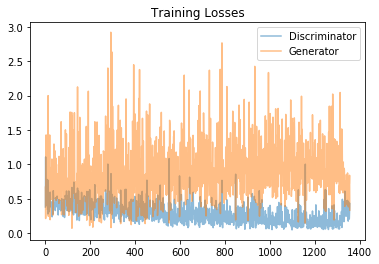

In [184]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [191]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [192]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

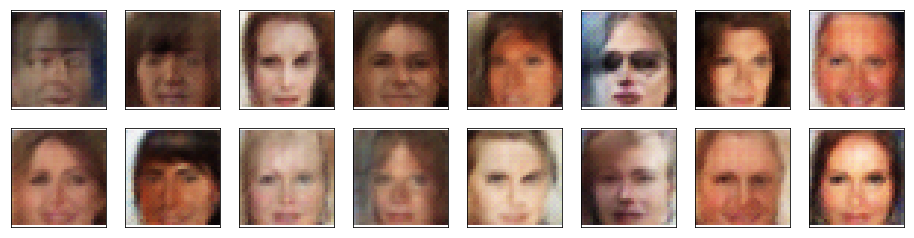

In [193]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Improving the model
1. Include more faces that are non-celebrities, also of different ethnicities, maybe more evenly distributed
2. I would also include more hyperparameters to test including DropOut rates for the Generator (G) and Discriminator (D_ and a dynamic learning_rate for both G and D.
3. Conventionally, I could also try for Leaky ReLU instead of standard ReLU, of course I could also include more layers in both convolutional and deconvolutional.
4. If the goal was simply to make believeable faces, I think a black and white transformation would have also been better. I could see this having the added simplicity of having a singular channel instead of the RGB. This should help with both speed and "eye"-test. From the generated sample image for instance - there are weird spotches of different colors in the eyes and hair, that could be remedied if the samples and generated were grayscale.
5. Of course, increasing EPOCHs can improve results but given the D and G loss pattern I've noticed a better model structure looks to be the better answer.

### Improving the model, update:
After gettting feedback from my first submission:
1. Increased batch size to 32.
2. Implemented step learning rate.
    * I had implmenented the same thing for my CNN.
    * https://github.com/LeonVillanueva/MOOCs/blob/master/Udacity/TV%20Script%20Generation%20LSTM/dlnd_tv_script_generation.ipynb
3. Implemented LeakyReLU

Observation: Generator performance is better, but D and G are still not converging. D is too good, and/or G is not understanding faces.

### Improving the model, update 2:
1. I think I was in the cusp of convergence looking at the graph, and was by the end of epoch=12, stable. Increasing my epochs might have improved result. Though I would call this early (lucky) stopping.
2. After reading literature (https://arxiv.org/pdf/1511.06434.pdf) I changed the leaky ReLU to a negative = 0.2.
3. I wanted to keep the Step Learning Rate, so all I did was change the learning rate to 0.0004 which is near the recommended 0.0002 and had a decay of 90%.
4. Despite the blur, pictures looked better with less "breaks" by either color or feature.
5. I also implemented a Dropout for Generator because it wasn't performing well. I'm thinking that the model was too reliant on some features generated in what it considers "a face".

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.